In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
from transformers import AutoImageProcessor, ViTForMaskedImageModeling, ViTImageProcessor
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor: ViTImageProcessor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForMaskedImageModeling.from_pretrained("google/vit-base-patch16-224-in21k")

num_patches = (model.config.image_size // model.config.patch_size) ** 2
pixel_values = image_processor(images=image, return_tensors="pt").pixel_values
# create random boolean mask of shape (batch_size, num_patches)
bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool()

outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
loss, reconstructed_pixel_values = outputs.loss, outputs.reconstruction
list(reconstructed_pixel_values.shape)

In [ ]:
# image_processor, bool_masked_pos, pixel_values.shape
model

In [ ]:
import torch

q_coords = torch.arange(14)[:, None]
k_coords = torch.arange(14)[None, :]

# (q_coords + k_coords)
q_coords

In [ ]:
model.save_pretrained("./.checkpoint/test")

In [ ]:
dict = model.state_dict()
for name in dict:
    print(name, dict[name].shape)

In [ ]:
from transformers import (
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    ViTImageProcessor,
    ViTMAEConfig,
    ViTMAEForPreTraining,
)

config = ViTMAEConfig()
config.update(
    {
        "num_channels": 1,
        "image_size": 144,
    }
)
model = ViTMAEForPreTraining(config)

dict = model.state_dict()
src_image_processor: ViTImageProcessor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
src_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
src_dict = src_model.state_dict()

# migrate from facebook/vit-mae-base to 1 channel & size 144x144
for name in src_dict:
    src_state = src_dict[name]
    state = dict[name]

    if (
        name == "vit.embeddings.patch_embeddings.projection.weight"
    ):  # vit.embeddings.patch_embeddings.projection.weight torch.Size([768, 3, 16, 16])
        src_state = src_state.sum(dim=1, keepdim=True)
    if (
        name == "vit.embeddings.position_embeddings" or name == "decoder.decoder_pos_embed"
    ):  # [1, 197, -1] -> [1, 82, -1]
        cls = src_state[:, 0:1, :]
        src_state = src_state[:, 1:, :].reshape(1, 14, 14, -1)
        src_state = src_state[:, 0:9, 0:9, :].reshape(1, 81, -1)
        src_state = torch.cat([cls, src_state], dim=1)

    if name == "decoder.decoder_pred.weight":  # [768, 512] -> [256, 512]
        # shape (patch_size*patch_size*num_channels, 512)
        src_state = src_state.reshape(1, 16, 16, 3, 512)
        src_state = src_state.mean(dim=3)
        src_state = src_state.reshape(16 * 16, 512)

    if name == "decoder.decoder_pred.bias":  # [768] -> [256]
        src_state = src_state.reshape(1, 16, 16, 3)
        src_state = src_state.mean(dim=3)
        src_state = src_state.reshape(-1)

    if state.shape != src_state.shape:
        print("state NOT same", name, state.shape, src_state.shape)
        continue

    dict[name] = src_state

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(src_model, lora_config)

lora_model.save_pretrained("./.checkpoint/test/")

In [ ]:
from typing import List
from PIL import Image
from mos.models.sam import (
    SamVisionConfig,
    SamPromptEncoderConfig,
    SamMaskDecoderConfig,
    SamConfig,
    SamModel,
    SamProcessor,
    SamImageProcessor,
)

from mos.datasets.cmri.cmri_dataset2d import CmriDataset2d

from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torchvision import transforms


from torchviz import make_dot

from run.pretrain.sam.sam_dataset import SAMDataset, SAMDatasetItem


device = "cpu"

pretrain_model = "facebook/sam-vit-base"
local_files_only = True

image_size = 1024

model = SamModel.from_pretrained(pretrain_model, local_files_only=local_files_only).to(device)
processor = SamProcessor(
    image_processor=SamImageProcessor(
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
        pad_size={"width": image_size, "height": image_size},
        size={"longest_edge": image_size},
    )
)
vision_config = SamVisionConfig(image_size=image_size, mlp_ratio=1)
prompt_encoder_config = SamPromptEncoderConfig(image_size=image_size)
mask_decoder_config = SamMaskDecoderConfig()

image_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
    ]
)
segment_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
    ]
)
cmri_dataset = CmriDataset2d("cmri")
cmri_dataset.set_image_transform(image_transform)
cmri_dataset.set_segment_transform(segment_transform)
train_dataset = SAMDataset(cmri_dataset, processor=processor)
example: SAMDatasetItem = train_dataset[0]

train_dataloader = DataLoader(
    train_dataset,
    # collate_fn=SAMDataset.collate_fn,
    batch_size=7,
    shuffle=True,
)
batch: SAMDatasetItem = next(iter(train_dataloader))

(pixel_values,) = (batch["pixel_values"].to(device),)
(input_boxes,) = (batch["input_boxes"].to(device),)
ground_truth_segment = batch["ground_truth_segment"].to(device)


model.eval()
outputs = model(pixel_values=pixel_values, input_boxes=input_boxes, multimask_output=False)


predicted_masks = outputs.pred_masks.squeeze(1)

dot = make_dot(predicted_masks.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.format = "svg"
dot.render("torchviz-sample")
dot

In [2]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", local_files_only=True)
model = BertModel.from_pretrained("bert-base-multilingual-cased", local_files_only=True)
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)

/home/huping/miniconda3/envs/py39/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initia

In [3]:
# encoded_input
tokenizer.decode(encoded_input["input_ids"][0])

"[CLS] Replace me by any text you'd like. [SEP]"

In [14]:
import random

l = [9, 1, 5, 3, 4, 2]
random.choice(l), random.choice(l)

(9, 4)

In [5]:
# output.last_hidden_state.shape
output.last_hidden_state[0, 0, :].shape

torch.Size([768])

In [3]:
import numpy as np
import torch

from mos.utils.tensors import load_tensor_file


t = load_tensor_file("/home/huping/dataset/acdc/001/001-12.npz")

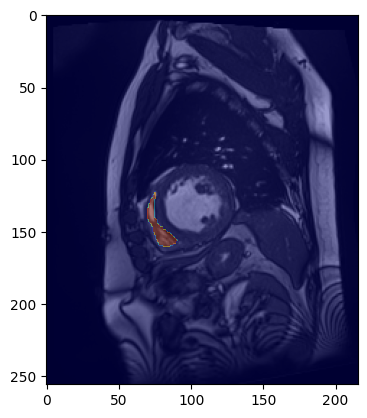

In [11]:
t = load_tensor_file("/home/huping/dataset/acdc/001/001-12.npz")
# t = load_tensor_file('/home/huping/dataset/mnms/a0s9v9/a0s9v9-01.npz')
image, segment = t["image"], t["segment"]

slice = 5
image, segment = image[slice, :, :], segment[slice, :, :]
# torch.unique(segment)
# segment.max()

import torchvision

from mos.utils.plot.plot_notebook import plot_segment

# image = image.repeat(3, 1, 1) * 255
# image = image.to(torch.uint8)
# segment = segment.to(torch.bool)
# torchvision.utils.draw_segmentation_masks(image, segment)
segment = torch.where(segment == 1, 1, 0)

# image = image.rot90(1, [0, 1])
# segment = segment.rot90(1, [0, 1])
plot_segment(image, segment, alpha=0.4)

In [4]:
t = load_tensor_file("/data2/huping/ACDC-database/patient001/patient001_frame01_gt.nii.gz")

NiftiImageIO (0x4315090): /data2/huping/ACDC-database/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x4315090): /data2/huping/ACDC-database/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform



In [7]:
image = t[""]
image = image[1:2, :, :].long()
kls = image.max().item()

import torch.nn.functional as F

# F.one_hot(image, num_classes=-1)[0,0,0,:]
# torch.where(image==1, 1, 0)
# random.randint(0, 1)
image.unique().tolist()

[0, 1, 2, 3]

In [2]:
import hashlib

m = hashlib.md5()
m.update(b"acdc")
m.digest()
hashlib.md5("whatever your string is".encode("utf-8")).hexdigest()

'855f938d67b52b5a7eb124320a21a139'

In [29]:
import numpy as np
import torch

from mos.utils.tensors import load_tensor_file
import torchvision.transforms as transforms

t = load_tensor_file("/home/dev/dataset/cmri/013/013-29.npz")
segment = t["segment"]
_segment_transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Resize((256, 256), antialias=True),
        lambda x: x.round(),
    ]
)
# segment[9, :, :].max(), _segment_transform(segment)[9, :, :].max()
segment = segment[0:1, :, :]
bs, h, w = segment.shape
_, y_indices, x_indices = segment.nonzero(as_tuple=True)
count = y_indices.size().numel()
index = np.random.choice(count, 5, replace=False)
x, y = x_indices[index].tolist(), y_indices[index].tolist()
print(x, y)
[(x * 1, y * 1) for x, y in zip(x, y)]

[141, 138, 129, 155, 119] [182, 182, 185, 110, 183]


[(141, 182), (138, 182), (129, 185), (155, 110), (119, 183)]

In [51]:
import os

last_model = "./.cache/models/sam_model-latest.pt"
epoch_model = "./.cache/models/sam_model-150.pt"


def relative_symlink(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    os.makedirs(os.path.dirname(src), exist_ok=True)
    os.remove(dst)
    dir = os.path.dirname(dst)
    src = os.path.relpath(src, dir)
    dst = os.path.join(dir, os.path.basename(dst))
    return os.symlink(src, dst)


relative_symlink(epoch_model, last_model)
os.path.exists(last_model)

True

In [1]:
import torch

device = "cuda:0"
param_list = torch.rand((128, 128, 128, 128), device=device)
param_list = param_list.type(torch.bool)
allo = torch.cuda.memory_allocated(device=device)
allo

268435456

In [5]:
import torch
import os

base = ".checkpoint/sammae-ck2020/epoch-0520"
param_list = torch.load(f"{base}/model.pt")
state = {}
for name in param_list:
    if name.startswith("vit."):
        print(name, "->", name[4:])
        state[name[4:]] = param_list[name]
torch.save(state, f"{base}/vision_encoder.pt")
os.remove(f"{base}/model.pt")

vit.cls_token -> cls_token
vit.pos_embed -> pos_embed
vit.patch_embed.proj.weight -> patch_embed.proj.weight
vit.patch_embed.proj.bias -> patch_embed.proj.bias
vit.blocks.0.norm1.weight -> blocks.0.norm1.weight
vit.blocks.0.norm1.bias -> blocks.0.norm1.bias
vit.blocks.0.attn.qkv.weight -> blocks.0.attn.qkv.weight
vit.blocks.0.attn.qkv.bias -> blocks.0.attn.qkv.bias
vit.blocks.0.attn.proj.weight -> blocks.0.attn.proj.weight
vit.blocks.0.attn.proj.bias -> blocks.0.attn.proj.bias
vit.blocks.0.norm2.weight -> blocks.0.norm2.weight
vit.blocks.0.norm2.bias -> blocks.0.norm2.bias
vit.blocks.0.mlp.fc1.weight -> blocks.0.mlp.fc1.weight
vit.blocks.0.mlp.fc1.bias -> blocks.0.mlp.fc1.bias
vit.blocks.0.mlp.fc2.weight -> blocks.0.mlp.fc2.weight
vit.blocks.0.mlp.fc2.bias -> blocks.0.mlp.fc2.bias
vit.blocks.1.norm1.weight -> blocks.1.norm1.weight
vit.blocks.1.norm1.bias -> blocks.1.norm1.bias
vit.blocks.1.attn.qkv.weight -> blocks.1.attn.qkv.weight
vit.blocks.1.attn.qkv.bias -> blocks.1.attn.qkv.bias


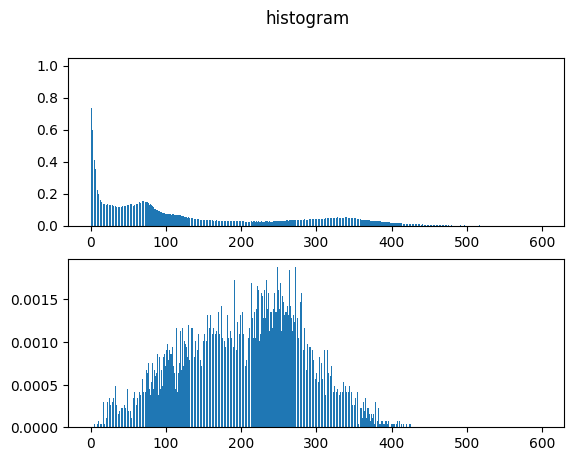

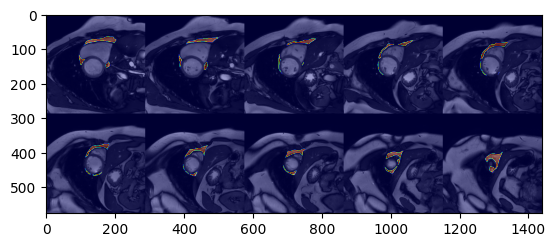

In [67]:
import torch, numpy as np
from mos.utils.plot.plot_notebook import plot_segment
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes

base_path = "/data2/huping/CMRI-out/step1-to-3d"

data = dict(np.load(f"{base_path}/001/001-01.npz"))
# data = dict(np.load(f"{base_path}/002/002-12.npz"))

image = data["image"]
segment = data["segment"]

image = torch.from_numpy(image).int().float()
segment = torch.from_numpy(segment).to(torch.bool).float()

images = image.split(1, dim=0)
segments = segment.split(1, dim=0)

image_list = []
segment_list = []

for i, s in zip(images, segments):
    if s.max() == 0:
        continue
    x1, y1, x2, y2 = [int(x) for x in masks_to_boxes(s).squeeze(0).tolist()]
    m = torch.zeros_like(s)
    m[:, y1:y2, x1:x2] = 1
    # i = i * m
    image_list.append(i)
    segment_list.append(s)

if len(image_list) % 2 == 1:
    image_list.pop()
    segment_list.pop()

image = torch.cat(image_list, dim=0)
segment = torch.cat(segment_list, dim=0)

d, h, w = image.shape

image = image.reshape(2, -1, h, w).permute(0, 2, 1, 3).reshape(2 * h, -1)
segment = segment.reshape(2, -1, h, w).permute(0, 2, 1, 3).reshape(2 * h, -1)

fig, axs = plt.subplots(2)
fig.suptitle("histogram")

bins = 600
image = image.clamp(0, bins)
global_histc = torch.histc(image, bins=bins, min=1, max=bins)
total_pixels = global_histc.max()
global_histc = global_histc / total_pixels
axs[0].bar(range(0, bins), global_histc, align="center")

seg_image = image * segment
seg_histc = torch.histc(seg_image, bins=bins, min=1, max=bins)
seg_histc = seg_histc / total_pixels

axs[1].bar(range(0, bins), seg_histc, align="center")
plt.show()
plot_segment(image, segment, alpha=0.4)
# image.shape, segment.shape

In [6]:
from typing import Any, Dict, Optional, Sequence, Tuple, Union
import torch


class CustomDataParallel(torch.nn.DataParallel):
    def scatter(
        self,
        inputs: Tuple[Any, ...],
        kwargs: Optional[Dict[str, Any]],
        device_ids: Sequence[Union[int, torch.device]],
    ) -> Any:
        all_device_param_list = []
        for device_index in device_ids:
            param_list = []
            for input in inputs:
                param_list.append(input[device_index])
            all_device_param_list.append(param_list)
        return all_device_param_list, ([kwargs for _ in device_ids])


class DModule(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        print(f"{len(x)}, {x.shape} \n {x} \n", type(x))


model = DModule().cuda()
model = CustomDataParallel(model)

data: list[torch.Tensor] = torch.arange(0, 32).unsqueeze(-1).float().cuda().split(8, 0)
data = [item.cuda(i) for i, item in enumerate(data)]
# data = [TensorWrapper(x) for x in data]
# print(data)
# print("---------")
model(data)

8, torch.Size([8, 1]) 
 tensor([[16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.]], device='cuda:2') 
 <class 'torch.Tensor'>
8, torch.Size([8, 1]) 
 tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.]], device='cuda:0') 
 <class 'torch.Tensor'>
8, torch.Size([8, 1]) 
 tensor([[ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]], device='cuda:1') 
 <class 'torch.Tensor'>
8, torch.Size([8, 1]) 
 tensor([[24.],
        [25.],
        [26.],
        [27.],
        [28.],
        [29.],
        [30.],
        [31.]], device='cuda:3') 
 <class 'torch.Tensor'>


In [1]:
import glob, os

base_path = '.checkpoint'

target_path = '.checkpoint-temp'

settings = ['baseline', 'baseline-cmri712-1', 'baseline-cmri712-2', 'baseline-cmri712-3', 'baseline-cmri712-4']

for setting in settings:
    # model_list:list[str] = glob.glob(f'*', root_dir=f'{base_path}/{setting}')
    model_list: list[str] = ['txtsam-2d-acdc,mnms', 'txtsam-2d-none', 'txtsam[p]-2d-acdc,mnms', 'txtsam[p]-2d-none']
    model_list.sort()
    for model in model_list:
        if '3d' not in model:
            continue
        epoches = glob.glob(f'epoch-*/model.pt', root_dir=f'{base_path}/{setting}/{model}')
        if len(epoches) == 0:
            continue

        print(f'process: {base_path}/{setting}/{model}/')
        os.makedirs(f'{target_path}/{setting}/{model}', exist_ok=True)
        epoches.sort(reverse=True)

        latest_epoch = epoches[0][:-9]

        os.system(f'rsync -arvPz {base_path}/{setting}/{model}/{latest_epoch} {target_path}/{setting}/{model}/')
        os.system(f'rsync -arvPz {base_path}/{setting}/{model}/latest {base_path}/{setting}/{model}/logs {target_path}/{setting}/{model}/')

        temp_epoch = os.readlink(f'{base_path}/{setting}/{model}/latest')
        if temp_epoch.startswith('temp'):
            os.system(f'rsync -arvPz {base_path}/{setting}/{temp_epoch} {target_path}/{setting}/{model}/')



    


process: .checkpoint/baseline/effsams-3d-none/
sending incremental file list

sent 192 bytes  received 17 bytes  418.00 bytes/sec
total size is 316,217,005  speedup is 1,513,000.02
sending incremental file list

sent 405 bytes  received 13 bytes  836.00 bytes/sec
total size is 612,709,358  speedup is 1,465,811.86
process: .checkpoint/baseline/effsamti-3d-none/
sending incremental file list

sent 229 bytes  received 17 bytes  492.00 bytes/sec
total size is 121,942,665  speedup is 495,701.89
sending incremental file list

sent 393 bytes  received 13 bytes  812.00 bytes/sec
total size is 331,097,681  speedup is 815,511.53
sending incremental file list


rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-5" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]
rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-4" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]



sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline/resunet++-3d-acdc,mnms/
sending incremental file list

sent 219 bytes  received 17 bytes  472.00 bytes/sec
total size is 502,073,385  speedup is 2,127,429.60
sending incremental file list

sent 348 bytes  received 13 bytes  722.00 bytes/sec
total size is 3,827,156,660  speedup is 10,601,541.99
sending incremental file list

sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline/resunet++-3d-none/
sending incremental file list

sent 213 bytes  received 17 bytes  460.00 bytes/sec
total size is 502,073,385  speedup is 2,182,927.76
sending incremental file list

sent 387 bytes  received 13 bytes  800.00 bytes/sec
total size is 2,775,511,875  speedup is 6,938,779.69
process: .checkpoint/baseline/resunet-3d-acdc,mnms/
sending incremental file list

sent 260 bytes  received 17 bytes  554.00 bytes/sec
total size is 452,772,8

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-6" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]



sent 448 bytes  received 13 bytes  922.00 bytes/sec
total size is 2,240,481,026  speedup is 4,860,045.61
process: .checkpoint/baseline/sam-3d-acdc,mnms/
sending incremental file list

sent 219 bytes  received 17 bytes  472.00 bytes/sec
total size is 1,124,077,433  speedup is 4,763,039.97
sending incremental file list

sent 555 bytes  received 13 bytes  1,136.00 bytes/sec
total size is 1,017,109,115  speedup is 1,790,685.06
sending incremental file list

sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline/sam-3d-none/
sending incremental file list

sent 203 bytes  received 17 bytes  440.00 bytes/sec
total size is 1,124,077,433  speedup is 5,109,442.88
sending incremental file list


rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-5" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]
rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-7" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]



sent 175 bytes  received 13 bytes  376.00 bytes/sec
total size is 1,737,688,183  speedup is 9,243,022.25
sending incremental file list

sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline/segnet-3d-acdc,mnms/
sending incremental file list
epoch-0900/
epoch-0900/model.pt
    353,259,046 100%   92.70MB/s    0:00:03 (xfr#1, to-chk=4/6)
epoch-0900/optimizer.pt
    706,378,554 100%   47.80MB/s    0:00:14 (xfr#2, to-chk=3/6)
epoch-0900/test-metrics.pt
          2,873 100%    0.00kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0900/test-metrics.pt.bk
          2,562 100%   10.25kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0900/valid-metrics.pt
          2,562 100%   10.05kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 942,246,207 bytes  received 115 bytes  45,963,235.22 bytes/sec
total size is 1,059,645,597  speedup is 1.12
sending incremental file list
latest -> epoch-0900
logs/
logs/events.out.tfevents.1704975205.lib0-server2.125260.0
         

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-4" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


     90,206,994 100%  213.92MB/s    0:00:00 (xfr#1, to-chk=4/6)
epoch-0900/optimizer.pt
    180,353,658 100%   22.37MB/s    0:00:07 (xfr#2, to-chk=3/6)
epoch-0900/test-metrics.pt
          2,873 100%    0.00kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0900/test-metrics.pt.bk
          2,050 100%    1.39kB/s    0:00:01 (xfr#4, to-chk=1/6)
epoch-0900/valid-metrics.pt
          2,562 100%    1.74kB/s    0:00:01 (xfr#5, to-chk=0/6)

sent 212,438,115 bytes  received 115 bytes  14,650,912.41 bytes/sec
total size is 270,568,137  speedup is 1.27
sending incremental file list
latest -> epoch-0900
logs/
logs/events.out.tfevents.1705043147.lib0-server2.687189.0
 10,983,723,964 100%   95.47MB/s    0:01:49 (xfr#1, to-chk=1/4)
logs/events.out.tfevents.1706161866.dev-precision3640tower.2170699.0
            533 100%    0.00kB/s    0:00:00 (xfr#2, to-chk=0/4)

sent 10,832,473,938 bytes  received 65 bytes  96,288,657.80 bytes/sec
total size is 10,983,724,507  speedup is 1.01
process: .checkpoint/baseline/

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline/temp-1" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    585,146,338 100%   66.52MB/s    0:00:08 (xfr#1, to-chk=4/6)
epoch-0900/optimizer.pt
  1,170,234,426 100%   57.91MB/s    0:00:19 (xfr#2, to-chk=3/6)
epoch-0900/test-metrics.pt
          2,873 100%   25.05kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0900/test-metrics.pt.bk
          2,562 100%   20.34kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0900/valid-metrics.pt
          2,562 100%   20.34kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 1,621,351,420 bytes  received 115 bytes  51,471,477.30 bytes/sec
total size is 1,755,388,761  speedup is 1.08
sending incremental file list
latest -> epoch-0900
logs/
logs/events.out.tfevents.1705118341.lib0-server2.1357638.0
    720,614,175 100%  154.84MB/s    0:00:04 (xfr#1, to-chk=4/7)
logs/events.out.tfevents.1705130294.lib0-server2.1477774.0
  1,210,610,418 100%  130.00MB/s    0:00:08 (xfr#2, to-chk=3/7)
logs/events.out.tfevents.1705149403.lib0-server2.1675934.0
            493 100%    2.24kB/s    0:00:00 (xfr#3, to-chk=2/7)
logs/events.out.tfevents.1705

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-1/temp-1" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


     80,950,458 100%  180.37MB/s    0:00:00 (xfr#2, to-chk=2/5)
epoch-0600/test-metrics.pt
          2,553 100%    5.83kB/s    0:00:00 (xfr#3, to-chk=1/5)
epoch-0600/valid-metrics.pt
          2,562 100%    5.85kB/s    0:00:00 (xfr#4, to-chk=0/5)

sent 110,296,803 bytes  received 96 bytes  73,531,266.00 bytes/sec
total size is 121,939,783  speedup is 1.11
sending incremental file list
latest -> epoch-0600
logs/
logs/events.out.tfevents.1706280358.lib0-server2.1046759.0
          8,182 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=1/4)
logs/events.out.tfevents.1706282276.lib0-server2.1064662.0
        183,744 100%  175.23MB/s    0:00:00 (xfr#2, to-chk=0/4)

sent 51,683 bytes  received 65 bytes  103,496.00 bytes/sec
total size is 191,936  speedup is 3.71
process: .checkpoint/baseline-cmri712-1/effsamti-3d-none/
sending incremental file list
epoch-0280/
epoch-0280/model.pt
     40,983,781 100%   24.11MB/s    0:00:01 (xfr#1, to-chk=3/5)
epoch-0280/optimizer.pt
     80,950,021 100%   28.69MB/s

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-1/temp-8" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    167,399,154 100%   73.55MB/s    0:00:02 (xfr#1, to-chk=4/6)
epoch-0200/optimizer.pt
    334,666,234 100%   57.98MB/s    0:00:05 (xfr#2, to-chk=3/6)
epoch-0200/test-metrics.pt
          2,553 100%    8.15kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0200/test-metrics.pt.bk
          2,562 100%    3.13kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0200/valid-metrics.pt
          2,562 100%    3.09kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 406,245,985 bytes  received 115 bytes  47,793,658.82 bytes/sec
total size is 502,073,065  speedup is 1.24
sending incremental file list
latest -> epoch-0200
logs/
logs/events.out.tfevents.1705917801.lib0-server2.2891115.0
    149,048,331 100%   82.67MB/s    0:00:01 (xfr#1, to-chk=3/6)
logs/events.out.tfevents.1705933436.lib0-server2.2928347.0
    435,053,447 100%   74.99MB/s    0:00:05 (xfr#2, to-chk=2/6)
logs/events.out.tfevents.1706016263.lib0-server2.3089283.0
            656 100%    0.84kB/s    0:00:00 (xfr#3, to-chk=1/6)
logs/events.out.tfevents.17060170

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-1/temp-4" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]
rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-1/temp-4" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]



sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline-cmri712-1/resunet-3d-none/
sending incremental file list
epoch-0400/
epoch-0400/model.pt
    150,948,665 100%  188.63MB/s    0:00:00 (xfr#1, to-chk=4/6)
epoch-0400/optimizer.pt
    301,814,213 100%   63.99MB/s    0:00:04 (xfr#2, to-chk=3/6)
epoch-0400/test-metrics.pt
          2,110 100%    0.00kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0400/test-metrics.pt.bk
          2,117 100%  114.85kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0400/valid-metrics.pt
          2,117 100%  108.81kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 416,054,821 bytes  received 115 bytes  64,008,451.69 bytes/sec
total size is 452,769,222  speedup is 1.09
sending incremental file list
latest -> epoch-0400
logs/
logs/events.out.tfevents.1705994436.dev-gpu0.875255.0
     81,582,947 100%   79.44MB/s    0:00:00 (xfr#1, to-chk=7/10)
logs/events.out.tfevents.1705995452.dev-gpu0.945875.0
    651,683,232 100%  106.

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-1/temp-5" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    353,259,046 100%  231.36MB/s    0:00:01 (xfr#1, to-chk=4/6)
epoch-0100/optimizer.pt
    706,378,554 100%  189.71MB/s    0:00:03 (xfr#2, to-chk=3/6)
epoch-0100/test-metrics.pt
          2,553 100%    4.27kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0100/test-metrics.pt.bk
          2,562 100%    4.09kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0100/valid-metrics.pt
          2,562 100%    3.99kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 979,209,268 bytes  received 115 bytes  178,038,069.64 bytes/sec
total size is 1,059,645,277  speedup is 1.08
sending incremental file list
latest -> epoch-0100
logs/
logs/events.out.tfevents.1705816874.ubuntu-SYS-7049GP-TRT.253211.0
  1,208,575,927 100%  191.01MB/s    0:00:06 (xfr#1, to-chk=0/3)

sent 1,206,416,476 bytes  received 46 bytes  185,602,541.85 bytes/sec
total size is 1,208,575,937  speedup is 1.00
process: .checkpoint/baseline-cmri712-1/segnet-3d-acdc,mnms[pretrain]/
sending incremental file list

sent 192 bytes  received 17 bytes  418.00 bytes/se

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-2/temp-2" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


     40,983,781 100%   29.21MB/s    0:00:01 (xfr#1, to-chk=3/5)
epoch-0130/optimizer.pt
     80,950,021 100%   36.54MB/s    0:00:02 (xfr#2, to-chk=2/5)
epoch-0130/test-metrics.pt
          2,430 100%    3.62kB/s    0:00:00 (xfr#3, to-chk=1/5)
epoch-0130/valid-metrics.pt
          1,797 100%    2.68kB/s    0:00:00 (xfr#4, to-chk=0/5)

sent 110,243,280 bytes  received 96 bytes  16,960,519.38 bytes/sec
total size is 121,938,029  speedup is 1.11
sending incremental file list
latest -> temp-6
logs/
logs/events.out.tfevents.1706427828.dev-precision3640tower.2945788.0
    217,434,420 100%  597.49MB/s    0:00:00 (xfr#1, to-chk=0/3)

sent 104,412,790 bytes  received 46 bytes  69,608,557.33 bytes/sec
total size is 217,434,426  speedup is 2.08
sending incremental file list

sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline-cmri712-2/effsamti-3d-none/
sending incremental file list
epoch-0260/
epoch-0260/model.pt


rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-2/temp-6" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


     40,983,781 100%   23.01MB/s    0:00:01 (xfr#1, to-chk=3/5)
epoch-0260/optimizer.pt
     80,950,021 100%   29.43MB/s    0:00:02 (xfr#2, to-chk=2/5)
epoch-0260/test-metrics.pt
          2,430 100%  395.51kB/s    0:00:00 (xfr#3, to-chk=1/5)
epoch-0260/valid-metrics.pt
          1,797 100%    1.20kB/s    0:00:01 (xfr#4, to-chk=0/5)

sent 109,816,584 bytes  received 96 bytes  10,458,731.43 bytes/sec
total size is 121,938,029  speedup is 1.11
sending incremental file list
latest -> temp-7
logs/
logs/events.out.tfevents.1706191906.dev-gpu0.308186.0
    112,999,208 100%  115.84MB/s    0:00:00 (xfr#1, to-chk=15/18)
logs/events.out.tfevents.1706245337.dev-gpu0.552696.0
     79,441,023 100%   68.97MB/s    0:00:01 (xfr#2, to-chk=14/18)
logs/events.out.tfevents.1706251075.dev-gpu0.3321807.0
            588 100%    5.63kB/s    0:00:00 (xfr#3, to-chk=13/18)
logs/events.out.tfevents.1706251163.dev-gpu0.3366731.0
      4,397,588 100%   24.82MB/s    0:00:00 (xfr#4, to-chk=12/18)
logs/events.out.tfe

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-2/temp-7" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    167,399,154 100%  221.07MB/s    0:00:00 (xfr#1, to-chk=4/6)
epoch-0200/optimizer.pt
    334,666,234 100%   28.40MB/s    0:00:11 (xfr#2, to-chk=3/6)
epoch-0200/test-metrics.pt
          2,873 100%    9.14kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0200/test-metrics.pt.bk
          2,242 100%    6.95kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0200/valid-metrics.pt
          2,242 100%    6.76kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 406,330,230 bytes  received 115 bytes  32,506,427.60 bytes/sec
total size is 502,072,745  speedup is 1.24
sending incremental file list
latest -> epoch-0200
logs/
logs/events.out.tfevents.1705979117.lib0-server2.3023716.0
    356,483,197 100%   88.39MB/s    0:00:03 (xfr#1, to-chk=2/5)
logs/events.out.tfevents.1706016272.lib0-server2.3089410.0
      5,649,741 100%   12.98MB/s    0:00:00 (xfr#2, to-chk=1/5)
logs/events.out.tfevents.1706017041.lib0-server2.3092961.0
    227,680,449 100%  104.33MB/s    0:00:02 (xfr#3, to-chk=0/5)

sent 584,508,300 bytes  received

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-4/temp-5" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    167,399,154 100%  254.57MB/s    0:00:00 (xfr#1, to-chk=3/5)
epoch-0090/optimizer.pt
    334,666,234 100%  184.70MB/s    0:00:01 (xfr#2, to-chk=2/5)
epoch-0090/test-metrics.pt
          2,873 100%    3.80kB/s    0:00:00 (xfr#3, to-chk=1/5)
epoch-0090/valid-metrics.pt
          2,562 100%    3.39kB/s    0:00:00 (xfr#4, to-chk=0/5)

sent 406,340,516 bytes  received 96 bytes  162,536,244.80 bytes/sec
total size is 502,070,823  speedup is 1.24
sending incremental file list
latest -> temp-9
logs/
logs/events.out.tfevents.1706160066.lib0-server2.347499.0
    326,017,141 100%   66.61MB/s    0:00:04 (xfr#1, to-chk=0/3)

sent 276,222,191 bytes  received 46 bytes  50,222,224.91 bytes/sec
total size is 326,017,147  speedup is 1.18
sending incremental file list

sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
process: .checkpoint/baseline-cmri712-4/resunet++-3d-none/
sending incremental file list
epoch-0400/
epoch-0400/model.pt


rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-4/temp-9" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    167,399,154 100%  119.65MB/s    0:00:01 (xfr#1, to-chk=4/6)
epoch-0400/optimizer.pt
    334,666,234 100%   64.93MB/s    0:00:04 (xfr#2, to-chk=3/6)
epoch-0400/test-metrics.pt
          2,873 100%    4.21kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0400/test-metrics.pt.bk
          2,562 100%    3.27kB/s    0:00:00 (xfr#4, to-chk=1/6)
epoch-0400/valid-metrics.pt
          2,562 100%    3.27kB/s    0:00:00 (xfr#5, to-chk=0/6)

sent 405,625,121 bytes  received 115 bytes  35,271,759.65 bytes/sec
total size is 502,073,385  speedup is 1.24
sending incremental file list
latest -> epoch-0400
logs/
logs/events.out.tfevents.1705868449.lib0-server1.2594693.0
  1,350,325,977 100%   65.27MB/s    0:00:19 (xfr#1, to-chk=2/5)
logs/events.out.tfevents.1705898800.lib0-server1.2890374.0
            489 100%    0.00kB/s    0:00:00 (xfr#2, to-chk=1/5)
logs/events.out.tfevents.1705898984.lib0-server1.2891995.0
            489 100%    0.33kB/s    0:00:01 (xfr#3, to-chk=0/5)

sent 1,200,316,617 bytes  receiv

rsync: [sender] link_stat "/data/projects/src/github.com/any35/MOS/.checkpoint/baseline-cmri712-4/temp-4" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


    150,949,158 100%  210.42MB/s    0:00:00 (xfr#1, to-chk=4/6)
epoch-0400/optimizer.pt
    301,814,650 100%   66.23MB/s    0:00:04 (xfr#2, to-chk=3/6)
epoch-0400/test-metrics.pt
          2,873 100%    3.03kB/s    0:00:00 (xfr#3, to-chk=2/6)
epoch-0400/test-metrics.pt.bk
          2,562 100%    2.25kB/s    0:00:01 (xfr#4, to-chk=1/6)
epoch-0400/valid-metrics.pt
          2,562 100%    2.21kB/s    0:00:01 (xfr#5, to-chk=0/6)

sent 415,549,485 bytes  received 115 bytes  75,554,472.73 bytes/sec
total size is 452,771,805  speedup is 1.09
sending incremental file list
latest -> epoch-0400
logs/
logs/events.out.tfevents.1705981235.lib0-server2.3026065.0
  1,122,701,519 100%   51.66MB/s    0:00:20 (xfr#1, to-chk=0/3)

sent 930,131,823 bytes  received 46 bytes  39,580,079.53 bytes/sec
total size is 1,122,701,529  speedup is 1.21
process: .checkpoint/baseline-cmri712-4/sam-3d-none/
sending incremental file list
epoch-0110/
epoch-0110/model.pt
    375,041,301 100%   76.37MB/s    0:00:04 (xfr#1,